In [35]:
import pandas as pd
pd.set_option('display.max_columns', None)

# read csv from github url
# return pandas dataframe
url = 'https://raw.githubusercontent.com/prathikr/CS_499_Final_Project/master/BISTRA_GROUP_PROJECT_SMALL.csv'
df = pd.read_csv(url)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a24651518>]],
      dtype=object)

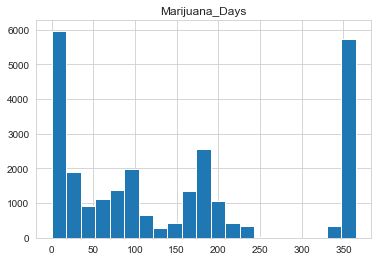

In [36]:
df = df[df.Marijuana_Days != -999] # removes all rows with Marijuana_Days = -999
df['zipcode'] = df['zipcode'].str[:5] # trim zip codes down to first 5 digits
df.hist(column='Marijuana_Days', bins=21) # 21 chosen so that there would be 3 bins between each x-axis number

In [37]:
print("Original df:", df.shape)

unused_potential_predictors = ['SFS8p_0', 'SFS8p_3', 'SFS8p_6', 'SFS8p_12', 'ada_0','ada_3',
'ada_6','ada_12','S2c1_0','S2c1_3','S2c1_6','S2c1_12','S2b1_0','S2b1_3','S2b1_6','S2b1_12','S2z1_3','S2z1_6',
'S2z1_12','S2z2_3','S2z2_6','S2z2_12','S2z3_3','S2z3_6','S2z3_12','S2z4_3','S2z4_6','S2z4_12','S2z5_3','S2z5_6',
'S2z5_12','Any_Cens','Alcohol_Cens','Binge_Cens','Marijuana_Cens','Illicit_Cens','Any_Days','Binge_Days',
'Alcohol_Days','Illicit_Days']

domain_expert_cols_to_drop = ['SPSy_0', 'loc', 'AFSS_0', 'E9a', 'E9b', 'E9c', 'E9d', 'E9e', 'E9e18', 'E9f', 'ID', 
'E9g', 'E9h', 'E9j', 'E9k', 'E9m', 'txtypeg', 'S7e4_0', 'engage42', 'POPIgrp','L5', 'E14a_0', 'E14b_0', 'SDScrY']

text_columns = ['City', 'agyaddr', 'zipcode', 'State']

cols_to_drop = text_columns + domain_expert_cols_to_drop + unused_potential_predictors

# drop columns and isolate to specific substance
df.drop(columns=cols_to_drop, inplace=True)
df = df[df.primsev == 3] # leaves only marijuana drug abusers in dataframe
df.drop(columns=['primsev'], inplace=True)
print("Updated df:", df.shape)

Original df: (26490, 110)
Updated df: (14166, 41)


In [38]:
import numpy as np
from IPython.display import display_html

def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

# replace all -999 with NaN inplace
df.replace(to_replace = -999, value = np.nan, inplace=True)

# calculate percentage of NaNs in each column
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,'percent_missing': percent_missing})
third = int(round(len(missing_value_df) / 3))
display_side_by_side(missing_value_df[0:third], missing_value_df[third:third*2], missing_value_df[third*2:len(missing_value_df)])

,column_name,percent_missing
female,female,0.000000
nonwhite,nonwhite,0.035296
unemplmt,unemplmt,0.197656
B2a_0,B2a_0,0.000000
noins,noins,59.819286
prsatx,prsatx,0.268248
tottxp4,tottxp4,0.000000
TRI_0,TRI_0,1.221234
GVS,GVS,0.176479
tsd_0,tsd_0,0.232952


In [39]:
print("Original df:", df.shape)

# drop columns with > 25% NaNs
cols = []
for index, row in missing_value_df.iterrows():
    if row['percent_missing'] > 25:
      cols.append(row['column_name'])
df.drop(columns=cols, inplace=True)
print("columns dropped:", cols)
print("new df shape:", df.shape)

Original df: (14166, 41)
columns dropped: ['noins', 'RFQ33c', 'GSSI_0', 'press', 'PSSI_0', 'RERI13p_0', 'FIS4p_0']
new df shape: (14166, 34)


In [40]:
# identify boolean columns
bool_cols = [col for col in df 
             if np.isin(df[col].dropna().unique(), [0, 1]).all()]
print("bool_cols", bool_cols)

bool_cols ['female', 'nonwhite', 'unemplmt', 'prsatx', 'tsd_0', 'und15', 'dldiag', 'suicprbs_0', 'homeless_0', 'S6', 'ncar', 'engage30', 'init']


In [41]:
# replace boolean column NaNs with mode
for column in bool_cols:
    df[column].fillna(df[column].mode()[0], inplace=True)
    
# since binary columns are filled we can just replace all other NaNs with mean
for column in df.columns:
    if column != 'State' and column != 'zipcode':
        df[column].fillna(df[column].mean(), inplace=True)

# maybe find elegant way to just print % NaNs in entire df and if anything but 0% something went wrong
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,'percent_missing': percent_missing})
all_null = True
for index, row in missing_value_df.iterrows():
    if row['percent_missing'] > 0:
        all_null = False
        print(row['column_name'], "has null values!!!! rip...")
        
if all_null:
    print("\nno null values!!!! yay!!")


no null values!!!! yay!!


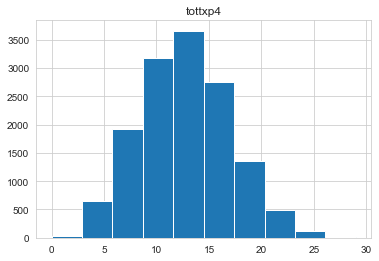

In [42]:
# normalize columns that are continuous
from sklearn import preprocessing

cols = ['tottxp4', 'CWS_0', 'ADHDs_0', 'CDS_0', 'CJSI_0', 'EPS7p_0', 'LRI7_0', 'SRI7_0', 
          'ERS21_0', 'HIVrisk', 'totttld', 'S2x_0', 'SPSm_0']

# visualize data histograms before normalization as a sanity check
df.hist(column=cols[0])

scaler = preprocessing.StandardScaler()
for i in cols:
    df[i] = scaler.fit_transform(df[[i]])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2431b0f0>]],
      dtype=object)

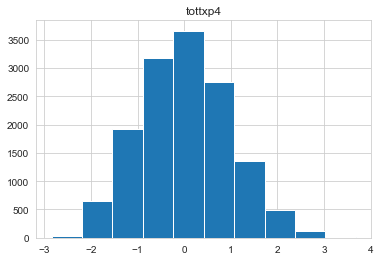

In [43]:
# visualize data histograms after normalization as a sanity check
df.hist(column=cols[0])

In [44]:
from sklearn.model_selection import train_test_split

# segment data by age (male == teenagers, female == adults)
# no reason for male/female discrimination, just too lazy to change variable names since copied from M_vs_F notebook
X_m = df[df.B2a_0 < 20].copy()
X_f = df[df.B2a_0 >= 20].copy()
X_m.drop(columns=['B2a_0'], inplace=True)
X_f.drop(columns=['B2a_0'], inplace=True)

print("Teenager Data:", X_m.shape, "Adult Data:", X_f.shape)

X_m_tr, X_m_te = train_test_split(X_m, test_size=0.2)
X_f_tr, X_f_te = train_test_split(X_f, test_size=0.2)

# extract Marujiana_Days predictor
Y_m_tr = X_m_tr['Marijuana_Days'].copy()
Y_m_te = X_m_te['Marijuana_Days'].copy()
Y_f_tr = X_f_tr['Marijuana_Days'].copy()
Y_f_te = X_f_te['Marijuana_Days'].copy()
X_m_tr.drop(columns=['Marijuana_Days'], inplace=True)
X_m_te.drop(columns=['Marijuana_Days'], inplace=True)
X_f_tr.drop(columns=['Marijuana_Days'], inplace=True)
X_f_te.drop(columns=['Marijuana_Days'], inplace=True)

Teenager Data: (13306, 33) Adult Data: (860, 33)


//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [45]:
import matplotlib.pyplot as plt
from sksurv.util import Surv
from sksurv.linear_model import CoxPHSurvivalAnalysis
import seaborn as sns

sns.set_style("whitegrid")

# generate male-only model with male training data
Y_m_tr_censored = Surv.from_arrays(Y_m_tr < 365, Y_m_tr.copy()) # structured array to ensure censoring of 365 value
model_m = CoxPHSurvivalAnalysis()
model_m.fit(X_m_tr, Y_m_tr_censored)

# generate female-only model with female training data
Y_f_tr_censored = Surv.from_arrays(Y_f_tr < 365, Y_f_tr.copy()) # structured array to ensure censoring of 365 value
model_f = CoxPHSurvivalAnalysis()
model_f.fit(X_f_tr, Y_f_tr_censored)

CoxPHSurvivalAnalysis(alpha=0, n_iter=100, ties='breslow', tol=1e-09, verbose=0)

In [46]:
# predict on male test data
pred_surv_m = model_m.predict_survival_function(X_m_te)
Y_m_te_censored = Surv.from_arrays(Y_m_te < 365, Y_m_te.copy()) # structured array to ensure censoring of 365 value
score_m = model_m.score(X_m_te, Y_m_te_censored)

print("Concordance Index:", score_m)

Concordance Index: 0.5865165791035272


In [47]:
# predict on female test data
pred_surv_f = model_f.predict_survival_function(X_f_te)
Y_f_te_censored = Surv.from_arrays(Y_f_te < 365, Y_f_te.copy()) # structured array to ensure censoring of 365 value
score_f = model_f.score(X_f_te, Y_f_te_censored)

print("Concordance Index:", score_f)

Concordance Index: 0.5554761223906205


Text(0.5, 1.0, 'Adults')

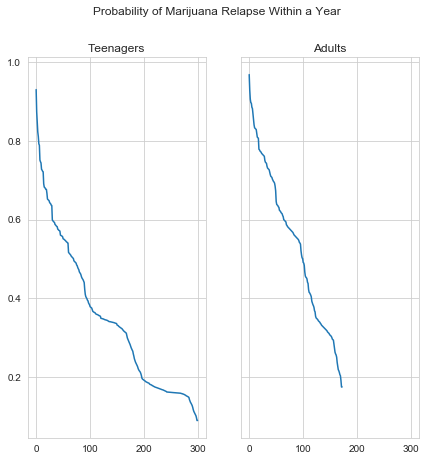

In [48]:
# display results side-by-side for comparison
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(7,7))
fig.suptitle('Probability of Marijuana Relapse Within a Year')
ax1.plot(np.mean([person.y for person in pred_surv_m], axis=0))
ax1.set_title('Teenagers')
ax2.plot(np.mean([person.y for person in pred_surv_f], axis=0))
ax2.set_title('Adults')